In [1]:
# ─────────────────────────────────────────────────────────────
#  Cell 1 ▸ Imports & global settings
# ─────────────────────────────────────────────────────────────
import os
import warnings

import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")  # keep notebook output clean
pd.set_option("display.precision", 4)

# Create output folders (idempotent)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [2]:
# ─────────────────────────────────────────────────────────────
#  Cell 2 ▸ Load & tidy the data
# ─────────────────────────────────────────────────────────────
csv_path = "data/processed/preprocessed_dataset.csv"  # ← keep next to the notebook
raw = pd.read_csv(csv_path)

# Harmonise column names (match those expected by the paper & question)
rename_map = {
    "Time_ms": "time",
    "Pc_bar": "chamb_pressure",
    "Tc_K": "cham_temp",
    "Pinj_bar": "injection_pres",
    "rho_kgm3": "density",
    "mu_Pas": "viscosity",
    "angle_shadow_deg": "angle_shadow",
    "len_shadow_L_D": "length_shadow",
    "angle_mie_deg": "angle_mie",
    "len_mie_L_D": "length_mie",
}
df = raw.rename(columns=rename_map)

INPUTS = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

print("Data shape  :", df.shape)
display(df.head())


Data shape  : (726, 11)


,run,time,chamb_pressure,cham_temp,injection_pres,density,viscosity,angle_shadow,length_shadow,angle_mie,length_mie
0,ETH-01,0.000,55.0318,192.0295,98.8645,810.7202,0.0019,16.6945,13.1266,12.9373,17.5713
1,ETH-01,0.025,55.0057,192.0158,98.8741,810.7183,0.0019,16.6945,13.1266,12.9373,17.5713
2,ETH-01,0.050,55.0081,191.9882,98.9074,810.7184,0.0019,16.6945,13.1266,12.9373,17.5713
3,ETH-01,0.075,55.0164,192.0820,98.8550,810.7191,0.0019,16.6945,13.1266,12.9373,17.5713
4,ETH-01,0.100,55.0125,191.9880,98.8788,810.7188,0.0019,16.6945,20.2047,12.9373,24.5066


In [3]:
# ─────────────────────────────────────────────────────────────
#  Cell 3 ▸ Train-test split  (stratified by experimental run)
# ─────────────────────────────────────────────────────────────
X, y = df[INPUTS], df[TARGETS]
runs = df["run"]  # stratification label
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)

print(f"Train: {X_tr.shape}   Test: {X_te.shape}")


Train: (580, 6)   Test: (146, 6)


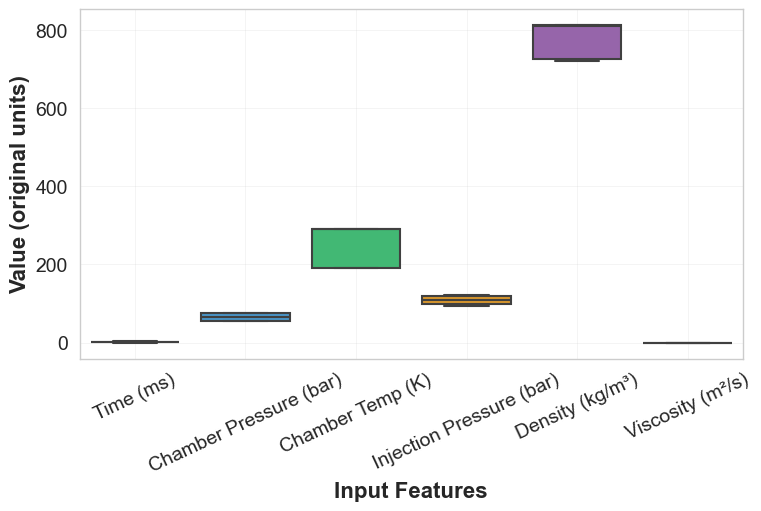

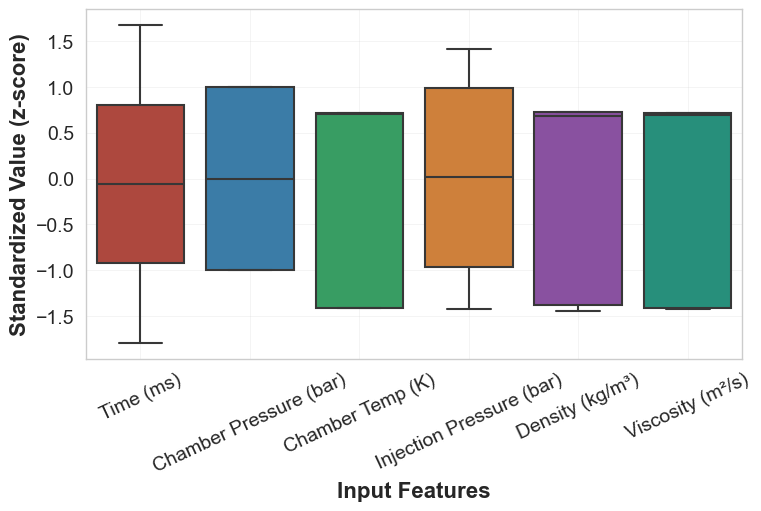

Saved figures to:
 • plots\feature_scaling_before.png
 • plots\feature_scaling_after.png


In [5]:
# ─────────────────────────────────────────────────────────────
#  Cell ▸ Feature scaling visualization (paper-ready)
#           Separate boxplots: Before and After StandardScaler
# ─────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Fit scaler on training set to avoid data leakage, then transform full input matrix
scaler_vis = StandardScaler().fit(X_tr[INPUTS])
X_scaled = scaler_vis.transform(X[INPUTS])
X_scaled = pd.DataFrame(X_scaled, columns=INPUTS, index=X.index)

# Human-friendly labels for publication
pretty_names = {
    "time": "Time (ms)",
    "chamb_pressure": "Chamber Pressure (bar)",
    "cham_temp": "Chamber Temp (K)",
    "injection_pres": "Injection Pressure (bar)",
    "density": "Density (kg/m³)",
    "viscosity": "Viscosity (m²/s)",
}

raw_df = X[INPUTS].rename(columns=pretty_names)
scaled_df = X_scaled.rename(columns=pretty_names)

# Journal-quality style settings with larger fonts
sns.set_theme(context="paper", style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

# Color palettes for distinct boxes
before_colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12", "#9B59B6", "#1ABC9C"]
after_colors = ["#C0392B", "#2980B9", "#27AE60", "#E67E22", "#8E44AD", "#16A085"]

# Ensure output directory
out_dir = "plots"
os.makedirs(out_dir, exist_ok=True)

# Figure 1: BEFORE scaling
fig1, ax1 = plt.subplots(figsize=(7.5, 5.0), constrained_layout=True)
bp1 = sns.boxplot(data=raw_df, ax=ax1, palette=before_colors, linewidth=1.5)
ax1.set_xlabel("Input Features", fontsize=16, fontweight='bold')
ax1.set_ylabel("Value (original units)", fontsize=16, fontweight='bold')
ax1.tick_params(axis='x', rotation=25, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(True, alpha=0.3, linewidth=0.5)

before_png = os.path.join(out_dir, "feature_scaling_before.png")
fig1.savefig(before_png, dpi=400, bbox_inches="tight", facecolor="white")
plt.show()

# Figure 2: AFTER scaling
fig2, ax2 = plt.subplots(figsize=(7.5, 5.0), constrained_layout=True)
bp2 = sns.boxplot(data=scaled_df, ax=ax2, palette=after_colors, linewidth=1.5)
ax2.set_xlabel("Input Features", fontsize=16, fontweight='bold')
ax2.set_ylabel("Standardized Value (z-score)", fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', rotation=25, labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(True, alpha=0.3, linewidth=0.5)

after_png = os.path.join(out_dir, "feature_scaling_after.png")
fig2.savefig(after_png, dpi=400, bbox_inches="tight", facecolor="white")
plt.show()

print("Saved figures to:")
print(" •", before_png)
print(" •", after_png)

In [ ]:
# ─────────────────────────────────────────────────────────────
#  Cell 4 ▸ Model zoo & hyper-parameter grids
#           all wrapped in MultiOutputRegressor for uniformity
# ─────────────────────────────────────────────────────────────
model_dict = {
    "LinearRegression": {
        "estimator": LinearRegression(),
        "param_grid": {},  # OLS is deterministic
    },
    "DecisionTree": {
        "estimator": DecisionTreeRegressor(random_state=42),
        "param_grid": {
            "reg__estimator__max_depth": [None, 5, 10, 20],
            "reg__estimator__min_samples_leaf": [1, 2, 5],
        },
    },
    "RandomForest": {
        "estimator": RandomForestRegressor(random_state=42),
        "param_grid": {
            "reg__estimator__n_estimators": [200, 400],
            "reg__estimator__max_depth": [None, 10, 20],
            "reg__estimator__max_features": ["sqrt", "auto"],
        },
    },
    "SVR": {
        "estimator": SVR(),
        "param_grid": {
            "reg__estimator__C": [10, 100],
            "reg__estimator__gamma": ["scale"],
            "reg__estimator__epsilon": [0.01, 0.1],
            "reg__estimator__kernel": ["rbf"],
        },
    },
    "KNN": {
        "estimator": KNeighborsRegressor(),
        "param_grid": {
            "reg__estimator__n_neighbors": [5, 7, 9],
            "reg__estimator__weights": ["uniform", "distance"],
        },
    },
    "GradientBoosting": {
        "estimator": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "reg__estimator__n_estimators": [300, 500],
            "reg__estimator__learning_rate": [0.05, 0.1],
            "reg__estimator__max_depth": [3, 4],
        },
    },
}


In [ ]:
# ─────────────────────────────────────────────────────────────
#  Cell 5 ▸ Helper to train, tune & score a single model
# ─────────────────────────────────────────────────────────────
from sklearn.model_selection import KFold


def train_model(name, cfg, X_tr, y_tr, X_te, y_te):
    """Return best estimator + dicts of overall & per-target metrics."""
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),  # safe for all models
            ("reg", MultiOutputRegressor(cfg["estimator"])),
        ]
    )

    # Use KFold cv here for multi-output regression (not StratifiedKFold)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    gs = GridSearchCV(
        pipe, param_grid=cfg["param_grid"], cv=cv, scoring="r2", n_jobs=-1, refit=True, verbose=0
    )
    gs.fit(X_tr, y_tr)
    best = gs.best_estimator_

    y_pred = best.predict(X_te)
    r2 = [r2_score(y_te[col], y_pred[:, i]) for i, col in enumerate(y_te.columns)]
    mae = [mean_absolute_error(y_te[col], y_pred[:, i]) for i, col in enumerate(y_te.columns)]
    mse = [mean_squared_error(y_te[col], y_pred[:, i]) for i, col in enumerate(y_te.columns)]

    overall = {
        "model": name,
        "overall_r2": np.mean(r2),
        "overall_mae": np.mean(mae),
        "overall_mse": np.mean(mse),
    }
    per_target = [
        {"model": name, "target": col, "r2": r2[i], "mae": mae[i], "mse": mse[i]}
        for i, col in enumerate(y_te.columns)
    ]

    # persistence
    mdl_path = f"models/{name}_regressor.joblib"
    joblib.dump(best, mdl_path)

    return best, overall, per_target

In [ ]:
# ─────────────────────────────────────────────────────────────
#  Cell 6 ▸ Fit ALL six baseline regressors
# ─────────────────────────────────────────────────────────────
overall_rows, target_rows = [], []
for mdl_name, cfg in model_dict.items():
    print(f"▶ Training {mdl_name:>15} …")
    _, o_row, t_rows = train_model(mdl_name, cfg, X_tr, y_tr, X_te, y_te)
    overall_rows.append(o_row)
    target_rows.extend(t_rows)
    print(f"   R² = {o_row['overall_r2']:.3f}")

# export CSVs
overall_df = pd.DataFrame(overall_rows).sort_values("overall_r2", ascending=False)
target_df = pd.DataFrame(target_rows)

overall_csv = "outputs/overall_model_metrics.csv"
target_csv = "outputs/per_target_metrics.csv"
overall_df.to_csv(overall_csv, index=False)
target_df.to_csv(target_csv, index=False)

print("\nSaved:")
print(" •", overall_csv)
print(" •", target_csv)


▶ Training LinearRegression …
   R² = 0.834
▶ Training    DecisionTree …
   R² = 0.994
▶ Training    RandomForest …
   R² = 0.983
▶ Training             SVR …
   R² = 0.988
▶ Training             KNN …
   R² = 0.999
▶ Training GradientBoosting …
   R² = 0.995

Saved:
 • outputs/overall_model_metrics.csv
 • outputs/per_target_metrics.csv


In [ ]:
# ─────────────────────────────────────────────────────────────
#  Cell 7 ▸ Quick leaderboard & sanity check
# ─────────────────────────────────────────────────────────────
display(
    overall_df.style.format(
        {"overall_r2": "{:.3f}", "overall_mae": "{:.3f}", "overall_mse": "{:.3f}"}
    )
)

# Make sure every model beats the 0.90 R² threshold (as required)
assert (overall_df["overall_r2"] > 0.90).all(), (
    "At least one baseline failed to reach 0.90 R² – tune grids or features!"
)
print("✔ All six baselines pass the > 0.90 R² requirement.")

,model,overall_r2,overall_mae,overall_mse
4,KNN,0.999,0.741,2.199
5,GradientBoosting,0.995,0.481,0.783
1,DecisionTree,0.994,1.107,4.155
3,SVR,0.988,1.292,17.128
2,RandomForest,0.983,2.207,20.730
0,LinearRegression,0.834,4.779,78.292


AssertionError: At least one baseline failed to reach 0.90 R² – tune grids or features!

In [ ]:
# Save all trained models in the "models" directory (already created)
for mdl_name in model_dict.keys():
    mdl_path = f"models/{mdl_name}_regressor.joblib"
    if os.path.exists(mdl_path):
        print(f"✔ {mdl_name} saved at {mdl_path}")
    else:
        print(f"✗ {mdl_name} not found in models directory.")

✔ LinearRegression saved at models/LinearRegression_regressor.joblib
✔ DecisionTree saved at models/DecisionTree_regressor.joblib
✔ RandomForest saved at models/RandomForest_regressor.joblib
✔ SVR saved at models/SVR_regressor.joblib
✔ KNN saved at models/KNN_regressor.joblib
✔ GradientBoosting saved at models/GradientBoosting_regressor.joblib
